# Syosetu dataset analysis

Shousetsuka ni Narou (Syosetu) is a Japanese-language novel-uploading website.

Many of the works originating from this website have later been published as physical books and then adapted into anime.

The dataset used here belongs to a Kaggle competition where the objective is to predict how popular a given novel is based on its tags and other statistics.

In [1]:
import numpy as np
import pandas as pd 

We will need to install and import `japanize_matplotlib` to properly display Japanese characters in plots

In [2]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4f2a1972dd4f6d5a061cbdd7874a459afd6d8dc2c8a47a73a49b4806fde18aa4
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [3]:
import japanize_matplotlib

In [4]:
train = pd.read_csv("/kaggle/input/narou/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75544 entries, 0 to 75543
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   novel_id                   75544 non-null  int64  
 1   title                      75544 non-null  object 
 2   writer                     75542 non-null  object 
 3   biggenre                   75544 non-null  object 
 4   genre                      75544 non-null  object 
 5   keyword                    74800 non-null  object 
 6   isr15                      75544 non-null  object 
 7   isbl                       75544 non-null  object 
 8   isgl                       75544 non-null  object 
 9   iszankoku                  75544 non-null  object 
 10  istensei                   75544 non-null  object 
 11  istenni                    75544 non-null  object 
 12  kaiwaritu                  75544 non-null  float64
 13  length_per_story           75544 non-null  flo

# Explanation of the dataset columns:

* `novel_id` - ID of the novel
* `title` - Title of the novel
* `writer` - Author's username
* `biggenre` - Main genre of the novel (romance, fantasy, sci-fi etc.)
* `genre` - Subgenre of the novel (space, isekai etc.)
* `keyword` - Keywords assigned by the authors
* `isr15` - Does the novel have a 15+ age rating
* `isbl` - is the novel tagged as BL (~gay romance)
* `isgl` - is the novel tagged as GL (~lesbian romance)
* `iszankoku` - is the novel tagged as having violent / cruel scenes
* `istensei` - is the novel from the tensei genre (with the protagonist reincarnated in another world)
* `istenni` - is the novel from the teni genre (with the protagonist transported to another world) 
* `kaiwaritu` - percentage of lines in the novel that are dialogue
* `length_per_story` - average number of (Japanese*) characters per chapter
* `sasie_cnt_per_story` - average number of illustrations per chapter
* `time_per_story_submission` - average number of days between new chapters being uploaded
* `global_point` - `fav_novel_cnt`*2 + `all_point`. The target variable
* `fav_novel_cnt` - Number of bookmarks (number of users who added this novel to their favorites)
* `all_point` - Number of cumulative points given by all users (~cumulative rating)

`global_point` is the target variable and due to its definition `fav_novel_cnt` and `all_point` are also unavailable in the test dataset.

*Note: Due to the nature of the Japanese writing system, the number of characters in a text is usually significantly shorter than in the same text translated to English*

Let us see the distribution of the `global_point` target variable

In [5]:
train["global_point"].describe()

count     75544.000000
mean       1987.118845
std       12020.528996
min           0.000000
25%          12.000000
50%          40.000000
75%         290.000000
max      878871.000000
Name: global_point, dtype: float64

(array([7.5304e+04, 1.7800e+02, 3.6000e+01, 1.6000e+01, 5.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([     0. ,  87887.1, 175774.2, 263661.3, 351548.4, 439435.5,
        527322.6, 615209.7, 703096.8, 790983.9, 878871. ]),
 <BarContainer object of 10 artists>)

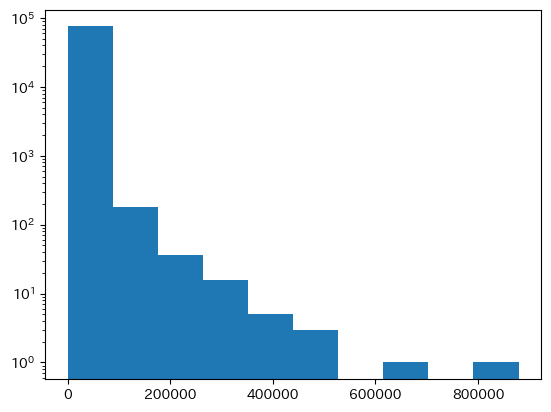

In [6]:
from matplotlib import pyplot as plt

plt.hist(train['global_point'], log=True)

The range of values that the column takes is very large - mainly due to outliers (few extremely popular novels). 

We can see this by looking at the 25th and 75th quantile, which are 12 and 290 respetively, while the max value is over 878 thousand.

# Initial genre / subgenre analysis

In [7]:
print(train["biggenre"].unique())
print(len(train["biggenre"].unique()))

['SF' '恋愛' 'ファンタジー' '文芸' 'その他' 'ノンジャンル']
6


As we can see, there are 6 "main genres" in this column:

* Science-fiction
* Romance
* Fantasy
* Literature
* Other
* None

<Axes: ylabel='count'>

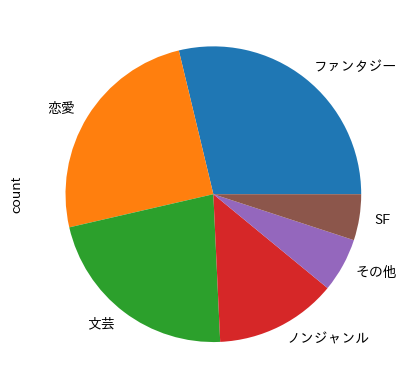

In [8]:
train["biggenre"].value_counts().plot(kind='pie')

<Axes: xlabel='biggenre'>

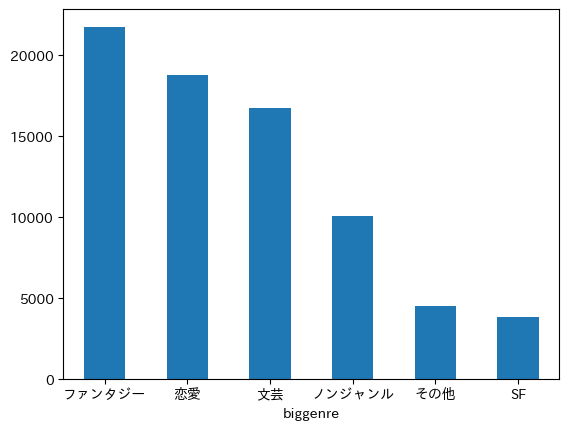

In [9]:
train["biggenre"].value_counts().plot(kind='bar', rot=0)

Most published novels on the site are fantasy novels, with romance being a close second.

Then literature, non-genre, others and science fiction at the end.

It's interesting to see how un-popular science fiction is on the site.

In [10]:
print(train["genre"].unique())
print(len(train["genre"].unique()))

['VRゲーム〔SF〕' '異世界〔恋愛〕' '現実世界〔恋愛〕' 'ローファンタジー〔ファンタジー〕' 'コメディー〔文芸〕'
 'ハイファンタジー〔ファンタジー〕' '歴史〔文芸〕' 'エッセイ〔その他〕' 'パニック〔SF〕' 'ヒューマンドラマ〔文芸〕'
 'ホラー〔文芸〕' '推理〔文芸〕' 'ノンジャンル〔ノンジャンル〕' '純文学〔文芸〕' '詩〔その他〕' 'リプレイ〔その他〕'
 '宇宙〔SF〕' 'アクション〔文芸〕' '空想科学〔SF〕' 'その他〔その他〕' '童話〔その他〕']
21


There are 21 subgenres, each belonging to one of the 6 main ones

* SF:
    * VR Game
    * Science Fiction
    * Panic
    * Space
* Romance
    * Isekai
    * Real-world 
* Fantasy
    * Low fantasy
    * High fantasy
* Literature
    * Comedy
    * History
    * Drama
    * Horror
    * Mystery
    * Action
    * Pure literature (純文学, with larger focus on the artistic aspects than entertainment)
* Other
    * Essay
    * Poem
    * Replay ([text replays of table-top rpg game playthroughs](https://syosetu.com/site/replay2/))
    * Fable
    * Other
* None
    * Non-genre

<Axes: ylabel='count'>

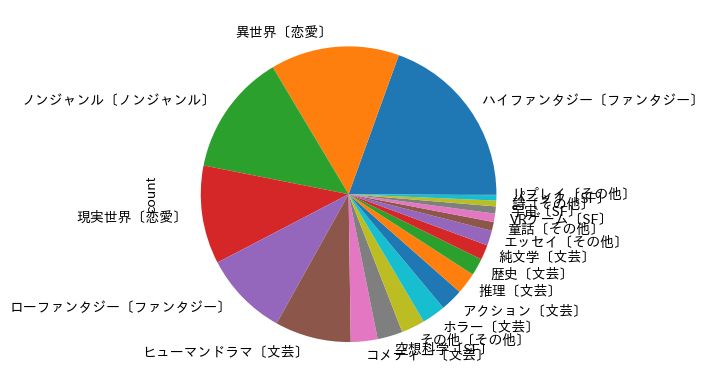

In [11]:
train["genre"].value_counts().plot(kind='pie')

<Axes: xlabel='genre'>

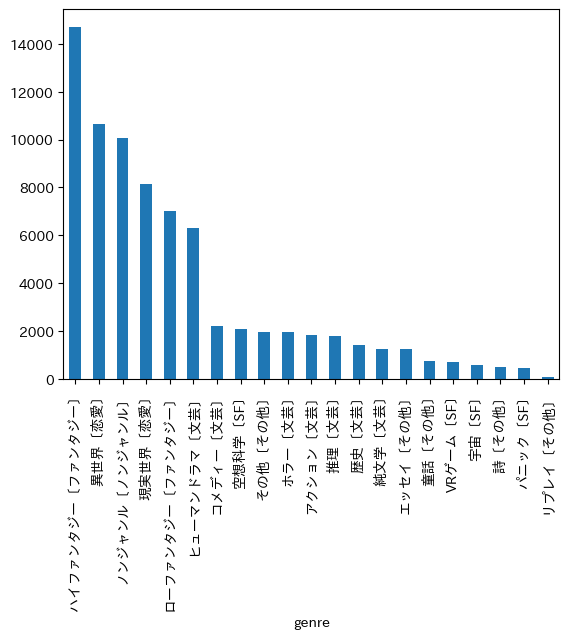

In [12]:
train["genre"].value_counts().plot(kind='bar')

About 75% of the novels on the site are assigned to one of the following 6 most popular subgenres:

* High fantasy
* Isekai (romance)
* Non-genre
* Real world
* Low fantasy
* Drama

## Isekai genre analysis

A lot of Japanese novels and anime released in the last 15 years use the isekai trope. There are two questions we can ask:

* Is this phenomenon visible in the Syosetu data as well (or is it limited to works in which publishers showed interest)?
* Is the average number of points that isekai works have different from that of the other novels?

In [13]:
print(train["istensei"].unique())
print(train["istenni"].unique())

['No' 'Yes']
['No' 'Yes']


In [14]:
isekai_novels = train.loc[(train['istensei'] == "Yes") | (train['istenni'] =="Yes")]
non_isekais = train.loc[train.index.difference(isekai_novels.index)]

In [15]:
print("Isekais:")
isekai_novels["global_point"].describe()

Isekais:


count     11633.000000
mean       4241.557036
std       21004.491482
min           0.000000
25%          40.000000
50%         238.000000
75%        1502.000000
max      878871.000000
Name: global_point, dtype: float64

In [16]:
print("Non-isekais:")
non_isekais["global_point"].describe()

Non-isekais:


count     63911.000000
mean       1576.768835
std        9455.237276
min           0.000000
25%          12.000000
50%          32.000000
75%         188.000000
max      505457.000000
Name: global_point, dtype: float64

Novels from the isekai/teni genre make up around 15.4% of the dataset

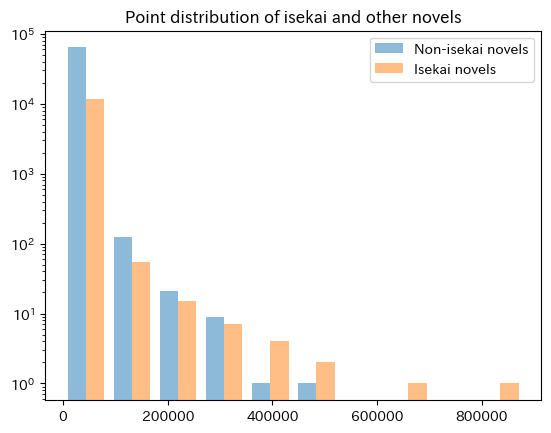

In [17]:
plt.hist([non_isekais["global_point"], isekai_novels["global_point"]], alpha=0.5, label=['Non-isekai novels','Isekai novels'], log=True)
plt.legend(loc='upper right')
plt.title("Point distribution of isekai and other novels")
plt.show()

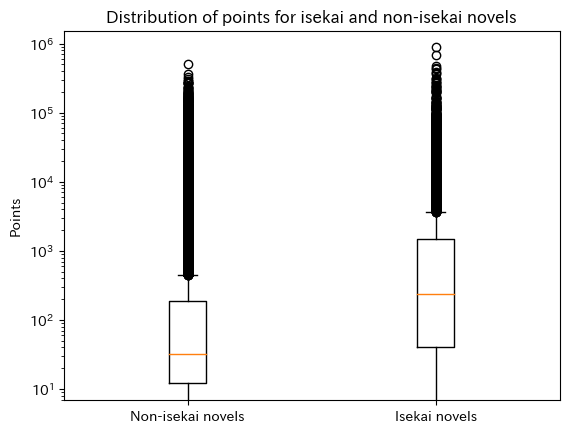

In [18]:
plt.boxplot(x=[non_isekais["global_point"], isekai_novels["global_point"]], labels=['Non-isekai novels','Isekai novels'])
plt.title("Distribution of points for isekai and non-isekai novels")
plt.yscale("log")
plt.ylabel("Points")
plt.show()

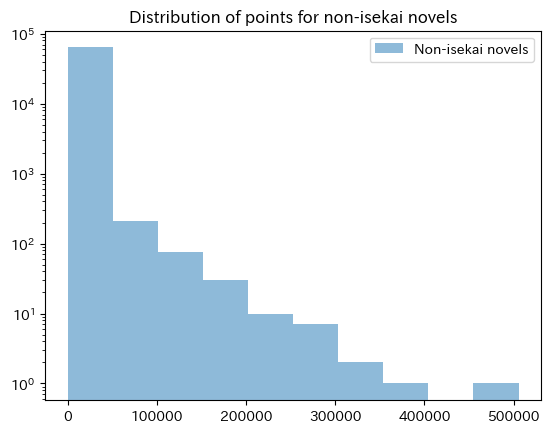

In [19]:
plt.hist(non_isekais["global_point"], alpha=0.5, label='Non-isekai novels', log=True)
plt.legend(loc='upper right')
plt.title("Distribution of points for non-isekai novels")
plt.show()

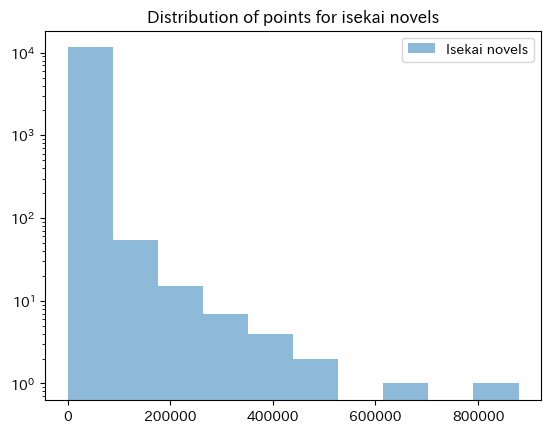

In [20]:
plt.hist(isekai_novels["global_point"], alpha=0.5, label='Isekai novels', log=True)
plt.legend(loc='upper right')
plt.title("Distribution of points for isekai novels")
plt.show()

At first glance, the distribution looks similar but shifted to the right.

Notably, the median number of points for isekais is **238** while for non-isekais it's just **32**

# Exploring the binary features

## BL / GL tags distribution

In [21]:
train["isbl"].value_counts()

isbl
No     73896
Yes     1648
Name: count, dtype: int64

In [22]:
train["isgl"].value_counts()

isgl
No     73055
Yes     2489
Name: count, dtype: int64

So apparently there's ~50% more novels tagged as GL than BL in the dataset.

Novels tagged as GL make up 3.3% of the dataset, while BL 2.1%

In [23]:
bl_novels = train.loc[(train['isbl'] == "Yes")]
gl_novels = train.loc[(train['isgl'] == "Yes")]

In [24]:
bl_novels["global_point"].describe()

count     1648.000000
mean       569.204490
std       3542.647584
min          0.000000
25%         12.000000
50%         31.000000
75%        120.000000
max      91050.000000
Name: global_point, dtype: float64

In [25]:
gl_novels["global_point"].describe()

count      2489.000000
mean        991.816392
std        5567.448883
min           0.000000
25%          20.000000
50%          72.000000
75%         346.000000
max      140306.000000
Name: global_point, dtype: float64

And the median number of points for GL novels is more than twice as high as that for BL.

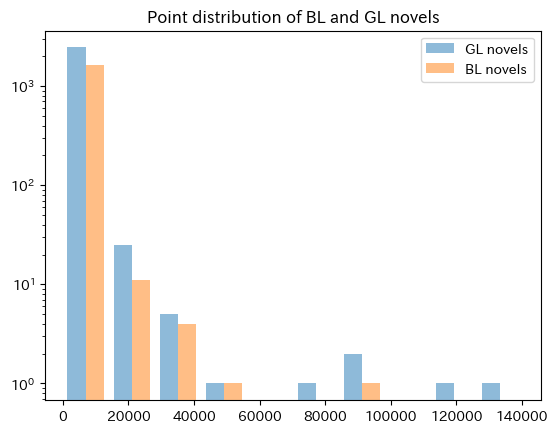

In [26]:
plt.hist([gl_novels["global_point"], bl_novels["global_point"]], alpha=0.5, label=['GL novels','BL novels'], log=True)
plt.legend(loc='upper right')
plt.title("Point distribution of BL and GL novels")
plt.show()

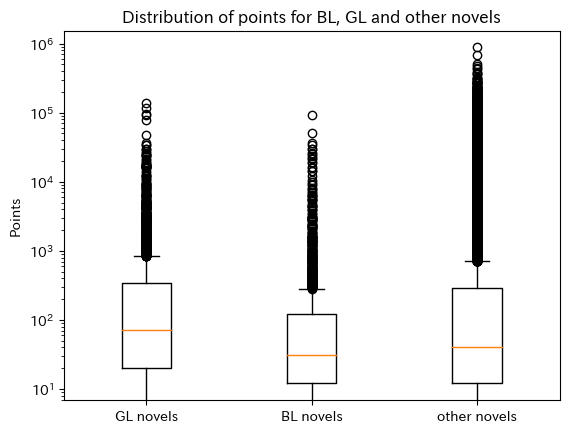

In [27]:
other_novels = train.loc[(train['isbl'] == "No")&(train['isgl'] == "No")]
plt.boxplot(x=[gl_novels["global_point"], bl_novels["global_point"],other_novels["global_point"]], labels=['GL novels','BL novels',"other novels"])
plt.title("Distribution of points for BL, GL and other novels")
plt.yscale("log")
plt.ylabel("Points")
plt.show()

## r15 and violent scenes tag

In [28]:
r15_novels = train.loc[(train['isr15'] == "Yes")]
non_r15_novels = train.loc[train.index.difference(r15_novels.index)]

In [29]:
violent_novels = train.loc[(train['iszankoku'] == "Yes")]
non_violent_novels = train.loc[train.index.difference(violent_novels.index)]

In [30]:
r15_novels["global_point"].describe()

count     29798.000000
mean       3167.709947
std       16168.420325
min           0.000000
25%          22.000000
50%         113.000000
75%         835.000000
max      878871.000000
Name: global_point, dtype: float64

In [31]:
non_r15_novels["global_point"].describe()

count     45746.000000
mean       1218.106173
std        8175.299969
min           0.000000
25%          10.000000
50%          26.000000
75%         118.000000
max      505457.000000
Name: global_point, dtype: float64

We can see that the novels with a 15+ age rating have a median number of points **4x** as high as the other ones and make up **61%** of the dataset.

In [32]:
violent_novels["global_point"].describe()

count     25026.000000
mean       2793.198833
std       16282.528148
min           0.000000
25%          18.000000
50%          78.000000
75%         566.000000
max      878871.000000
Name: global_point, dtype: float64

In [33]:
non_violent_novels["global_point"].describe()

count     50518.000000
mean       1587.796667
std        9179.236744
min           0.000000
25%          10.000000
50%          31.000000
75%         191.000000
max      426094.000000
Name: global_point, dtype: float64

And those that are not tagged as containing violent scenes have less than half as many points as those that are tagged.

Novels tagged as violent make up **67%** of the dataset

# Numeric columns

## Number of illustrations

In [34]:
train["sasie_cnt_per_story"].describe()

count    75544.000000
mean         0.034576
std          0.998168
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        183.615385
Name: sasie_cnt_per_story, dtype: float64

It's somewhat difficult to comment on this column since the vast majority of authors do not use the illustration functionality of the website when uploading their works.

<Axes: ylabel='Frequency'>

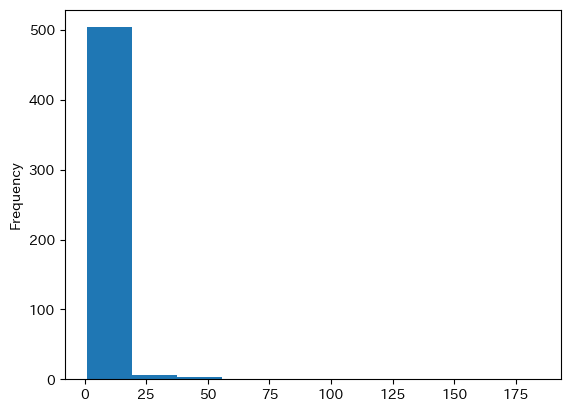

In [35]:
train["sasie_cnt_per_story"].plot(kind="hist",range=[1,184])

<Axes: ylabel='Frequency'>

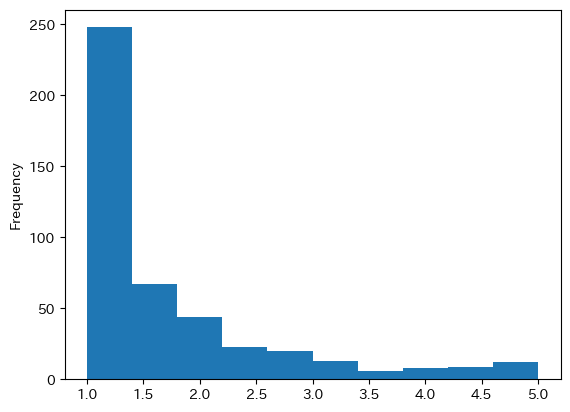

In [36]:
train["sasie_cnt_per_story"].plot(kind="hist",range=[1,5])

## Amount of dialogue

<Axes: ylabel='Frequency'>

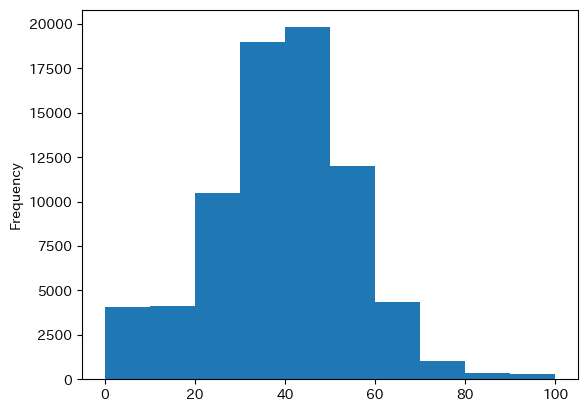

In [37]:
train["kaiwaritu"].plot(kind="hist")

Most novels on the site consist of around 50% dialogue, with more novels having next to no dialogue than being almost entirely dialogue (which makes sense, although there are some surprising outliers:)

### Some novels on the site consist almost entirely of dialogue

It's worth noting that this column is based on heuristics used internally by Syosetu, [as explained in Japanese here](https://dev.syosetu.com/man/kaiwa/)

<Axes: ylabel='Frequency'>

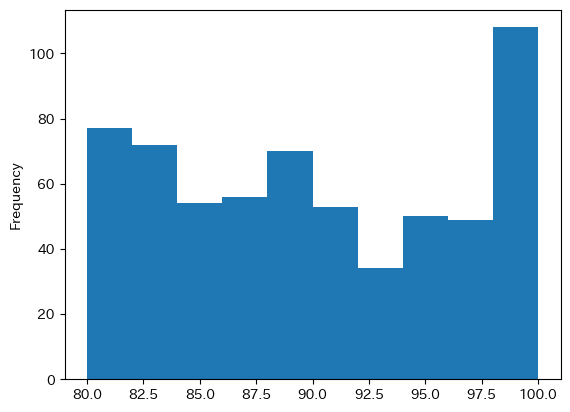

In [38]:
train["kaiwaritu"].plot(kind="hist", range=[80,100])

## Chapter length

<Axes: ylabel='Frequency'>

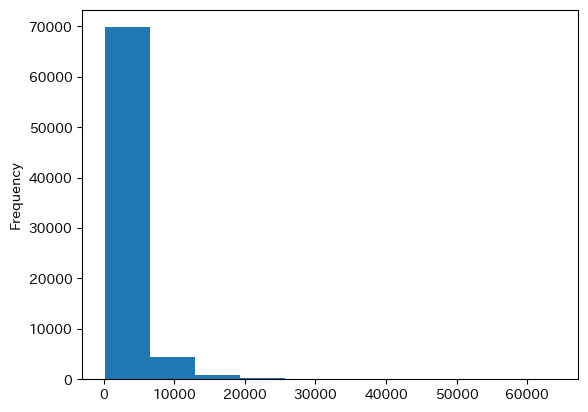

In [39]:
train["length_per_story"].plot(kind="hist")

<Axes: ylabel='Frequency'>

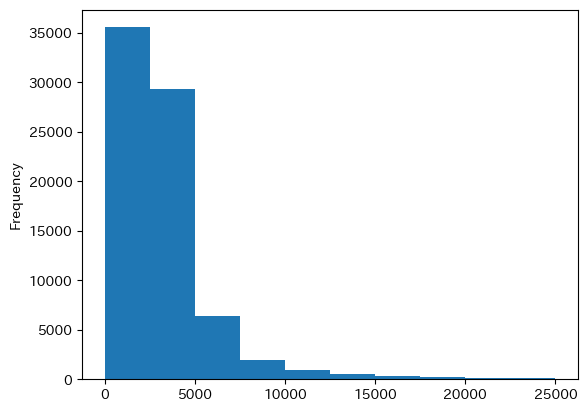

In [40]:
train["length_per_story"].plot(kind="hist", range=[0,25_000])

<Axes: ylabel='Frequency'>

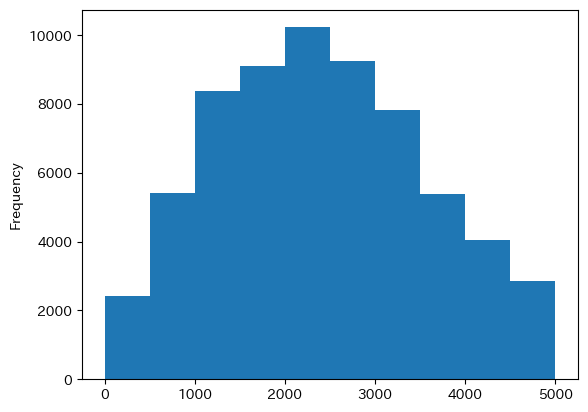

In [41]:
train["length_per_story"].plot(kind="hist", range=[0,5000])

Therefore the typical length of a chapter in a novel posted on syosetu is around 2300 characters.

## Frequency of updates

<Axes: ylabel='Frequency'>

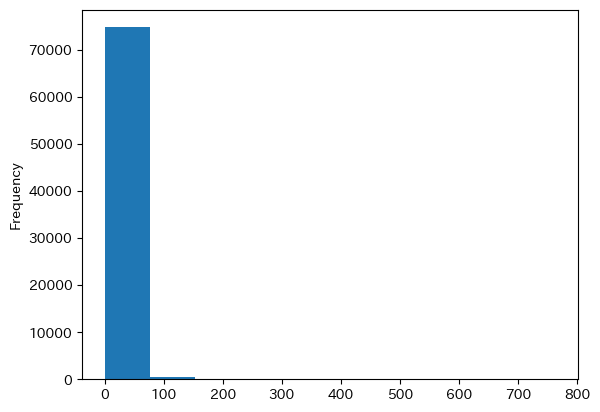

In [42]:
train["time_per_story_submission"].plot(kind="hist")

<Axes: ylabel='Frequency'>

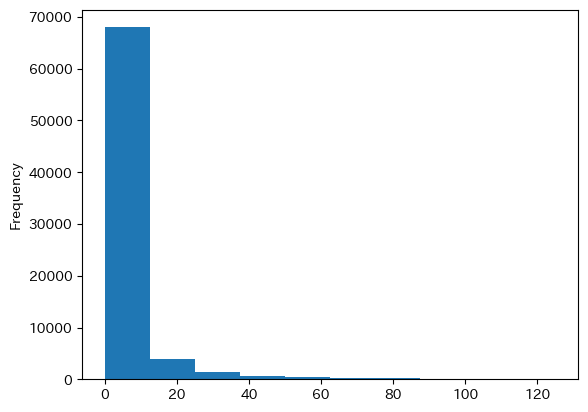

In [43]:
train["time_per_story_submission"].plot(kind="hist", range=[0,125])

<Axes: ylabel='Frequency'>

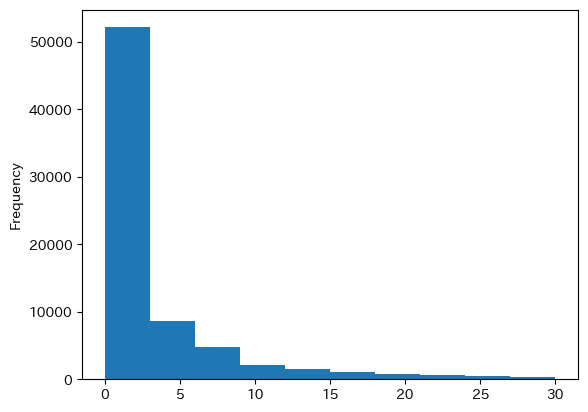

In [44]:
train["time_per_story_submission"].plot(kind="hist", range=[0,30])

We can see that the vast majority of novels in the dataset are updated extremely frequently - with a new chapter being added every few days

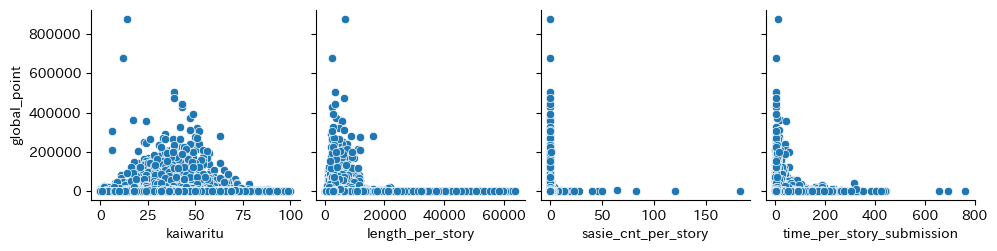

In [45]:
import seaborn as sns

sns.pairplot(data=train, y_vars="global_point",x_vars=["kaiwaritu","length_per_story","sasie_cnt_per_story","time_per_story_submission"])

It's hard to pinpoint some relationship between these columns and the number of points based only on those plots - they look quite similar to those of the distribution for each of the corresponding variables. This might suggest that any relationship between the explanatory and target variables here are quite weak.

# Keywords

In [46]:
train["keyword"].head()

0    R15 冒険 VRMMO 残念系女主人公 ほのぼの シリアス ミステリー風味要素 中世西洋風...
1    R15 異世界転生 女主人公 逆ハーレム？ チート 魔法 転生 聖女 大賢者 ドタバタ 勘違...
2              R15 スクールラブ 日常 青春 ラブコメ 純文学 恋愛 失恋 中学生 高校生
3                                    R15 残酷な描写あり 現代 和風
4                           日常 青春 ホームドラマ ラブコメ 近未来 人工知能
Name: keyword, dtype: object

We can see that the keywords are space-separated strings, some being the same as those in genres

In [47]:
train.fillna({"keyword":"UNTAGGED_NOVEL"}, inplace=True)

def str_tags_to_set(tags):
    return set(tags.split(" "))

keywords_set = train["keyword"].apply(lambda x: str_tags_to_set(x))
keywords_set_list = keywords_set.tolist()
keywords_collection = set()


for i in keywords_set_list:
    keywords_collection.update(i)
keywords_dict = dict()
for i, el in enumerate(keywords_collection):
    keywords_dict[el] = i

In [48]:
len(keywords_dict)

81075

There are over 81 thousand different tags so it is impossible to analyze all of them. Still, we can check the most popular ones:

In [49]:
from collections import Counter
keywords_array = train['keyword'].str.split()
keywords_array_flattened = [keyword for individual_list in keywords_array for keyword in individual_list]
keywords_counter = Counter(keywords_array_flattened)
most_popular_keywords = keywords_counter.most_common(100)

most_popular_keywords_df = pd.DataFrame(most_popular_keywords, columns=['keyword', 'frequency'])
print(most_popular_keywords_df)

       keyword  frequency
0          R15      29748
1      残酷な描写あり      25027
2           日常      14524
3           青春      13206
4         男主人公      12547
..         ...        ...
95          追放        903
96          純愛        867
97       VRMMO        859
98  コミックスピア大賞3        827
99      ディストピア        806

[100 rows x 2 columns]


In [50]:
most_popular_keywords_df[:10]

,keyword,frequency
0,R15,29748
1,残酷な描写あり,25027
2,日常,14524
3,青春,13206
4,男主人公,12547
5,女主人公,10966
6,恋愛,10804
7,ハッピーエンド,10749
8,シリアス,10452
9,魔法,9765


Some of these keywords overlap with the genre names, while some express different aspects of the works ("daily life", "happy ending", "serious", "magic")

# No. novels posted per author

In [51]:
train["writer"].value_counts()

writer
りょまるで             117
かいわれのせか           112
澄                 104
リィズ・ブランディシュカ       65
筑紫榛名@5/19文フリ東京     65
                 ... 
おふじくん               1
Rico                1
日野　哲太郎              1
酒月沢 杏               1
雪うさこ                1
Name: count, Length: 34771, dtype: int64

<Axes: ylabel='Frequency'>

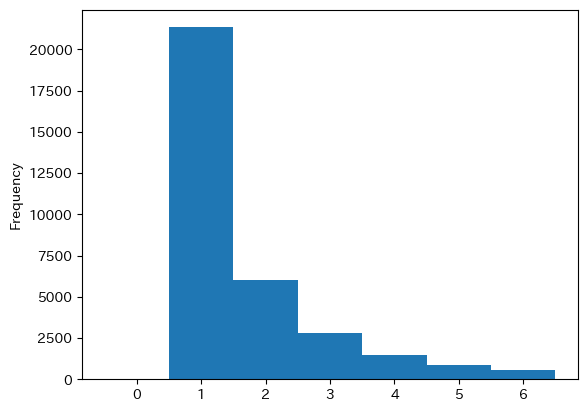

In [52]:
train["writer"].value_counts().plot(kind="hist", bins=[i-0.5 for i in range(8)])

The majority of authors posted only a single work to their site

# Finding the most popular novels in the train split

Since this is only the train split of the dataset, and the test split does not contain the popularity-related columns, we do not have all data needed to find the most popular novels on the site. Still, it might be interesting to see what we can find out.

In [53]:
train.sort_values('global_point', ascending=False)[:10]

,novel_id,title,writer,biggenre,genre,keyword,isr15,isbl,isgl,iszankoku,istensei,istenni,kaiwaritu,length_per_story,sasie_cnt_per_story,time_per_story_submission,global_point,fav_novel_cnt,all_point
8695,8695,転生したらスライムだった件,伏瀬,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 スライム チート,Yes,No,No,Yes,Yes,No,14.0,6722.203947,0.016447,8.851891,878871.0,315117.0,248637.0
13635,13635,蜘蛛ですが、なにか？,馬場翁,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 ファンタジー 異世界 転生 蜘蛛 女主人公 勇者 魔王 ...,Yes,No,No,Yes,Yes,No,12.0,2522.041667,0.000000,4.061717,676799.0,209964.0,256871.0
46772,46772,最強出涸らし皇子の暗躍帝位争い～帝位に興味ないですが、死ぬのは嫌なので弟を皇帝にしようと思います～,タンバ,ファンタジー,ハイファンタジー〔ファンタジー〕,残酷な描写あり 暗躍 謀略 主人公最強 剣 魔法 冒険者 騎士 帝位争い 優秀な弟 不出来な...,No,No,No,Yes,No,No,39.0,3241.515263,0.001221,2.230769,505457.0,121064.0,263329.0
58897,58897,乙女ゲー世界はモブに厳しい世界です,三嶋 与夢,ファンタジー,ローファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 乙女ゲーム 悪役令嬢 冒険 人工知能 男主人公 学園 近...,Yes,No,No,Yes,Yes,No,39.0,6533.494318,0.000000,4.223500,475691.0,129633.0,216425.0
52730,52730,限界超えの天賦《スキル》は、転生者にしか扱えない ー オーバーリミット・スキルホルダー,三上康明,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 主人公最強 （いずれ）,Yes,No,No,Yes,Yes,No,43.0,3429.745152,0.000000,1.549111,442134.0,82159.0,277816.0
7383,7383,公爵令嬢の嗜み,澪亜,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 異世界転生 悪役令嬢 転生,Yes,No,No,No,Yes,No,43.0,2398.781132,0.000000,3.543294,426094.0,147404.0,131286.0
36484,36484,転生したら剣でした,棚架ユウ,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 冒険 剣 ファンタジー 獣人 成長 スキル 魔石 チート...,Yes,No,No,Yes,Yes,No,49.0,2807.905344,0.000000,2.356981,392312.0,109721.0,172870.0
6079,6079,聖者無双 ～サラリーマン、異世界で生き残るために歩む道～,ブロッコリーライオン,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 異世界 転生 日進月歩の成長 アイテムチート？ いつかハ...,Yes,No,No,Yes,Yes,No,47.0,3814.520384,0.000000,6.777149,373452.0,131635.0,110182.0
5471,5471,【12/8 書籍 最終巻 発売】ゴブリン令嬢と転生貴族が幸せになるまで 婚約者の彼女のため...,新天新地,恋愛,異世界〔恋愛〕,R15 残酷な描写あり 身分差 ラブコメ イケメン男主人公 魔法 知識チート ハッピーエンド...,Yes,No,No,Yes,No,No,17.0,4914.769231,0.000000,18.461872,363116.0,38019.0,287078.0
16291,16291,乙女ゲームの破滅フラグしかない悪役令嬢に転生してしまった…,山口悟,恋愛,異世界〔恋愛〕,異世界転生 乙女ゲーム 悪役令嬢 転生 悪役 魔法 逆ハー(性別問わず) 犬とは犬猿の仲,No,No,No,No,Yes,No,24.0,5587.705882,0.000000,42.639868,358746.0,119808.0,119130.0


The two top novels visible above are [That Time I Got Reincarnated as a Slime](https://en.wikipedia.org/wiki/That_Time_I_Got_Reincarnated_as_a_Slime) and [So I'm a Spider, So What?](https://en.wikipedia.org/wiki/So_I%27m_a_Spider,_So_What%3F) respectively.

Based on a quick Google search, all of these novels have been published commercially (and are available on Amazon), and most of them have gotten anime adaptations by now.

We can also see the infamous tendency of Japanese novels to have unusually long titles. Let's plot that:

# Novel title length

Text(0.5, 0, 'Title length (characters)')

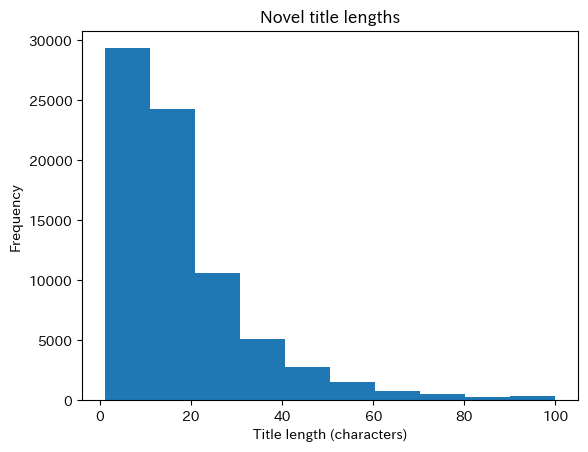

In [54]:
title_lengths = train["title"].apply(len)

plt.hist(title_lengths)
plt.title("Novel title lengths")
plt.ylabel("Frequency")
plt.xlabel("Title length (characters)")

The titles are quite long (which actually isn't very surprising to anyone interested in this topic). There's a large number of novels with titles that are up to 20 characters long.

What's most surprising here (at least to me) is that there appears to be a small "bump" in the number of novels that are just under the 100-character title limit.

Text(0.5, 0, 'Title length (characters)')

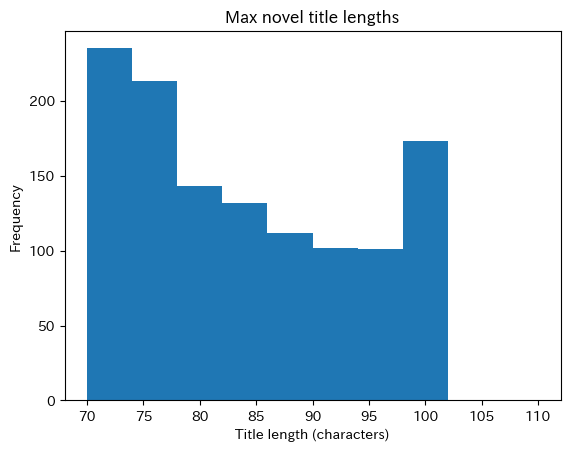

In [55]:
plt.hist(title_lengths, range=[70,110])
plt.title("Max novel title lengths")
plt.ylabel("Frequency")
plt.xlabel("Title length (characters)")

# Title complexity

Since the titles are in Japanese, there's one additional textual feature we can analyze without training a complicated embedding model - we can count the number of kanji (and possibly hiragana / katakana as well) and compare it to the length of the title. 

This should give us some basic idea of how complex (or semantically dense) these titles are. After all, a 30-character string composed mostly of kanji (theoretically) carries much more information than one written in katakana.

We will use a regex with some magic numbers (unicode ranges for each class of characters) to do this

In [56]:
import re

def count_kanji(text):
    return len(re.findall(r'[\u4E00-\u9FFF]', text))/len(text)

def count_hiragana(text):
    return len(re.findall(r'[\u3040-\u309F]', text))/len(text)

def count_katakana(text):
    return len(re.findall(r'[\u30A0-\u30FF]', text))/len(text)

train["title_kanji_rate"] = train["title"].apply(count_kanji)
train["title_hiragana_rate"] = train["title"].apply(count_hiragana)
train["title_katakana_rate"] = train["title"].apply(count_katakana)

In [57]:
train[["title","title_kanji_rate","title_hiragana_rate","title_katakana_rate"]].head()

,title,title_kanji_rate,title_hiragana_rate,title_katakana_rate
0,ティファレシア ～風信子の絆～,0.266667,0.066667,0.466667
1,大聖女様 世を謀る！,0.600000,0.200000,0.000000
2,どっとろくはんかく.おるた,0.000000,0.923077,0.000000
3,私情まみれのお仕事 侵入編,0.538462,0.384615,0.000000
4,メイロボっ,0.000000,0.200000,0.800000


Now that we have defined these features, let us check their distributions.

<Axes: ylabel='Frequency'>

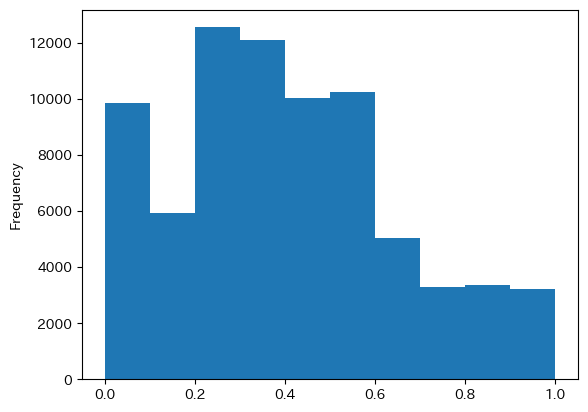

In [58]:
train["title_kanji_rate"].plot(kind="hist")

<Axes: ylabel='Frequency'>

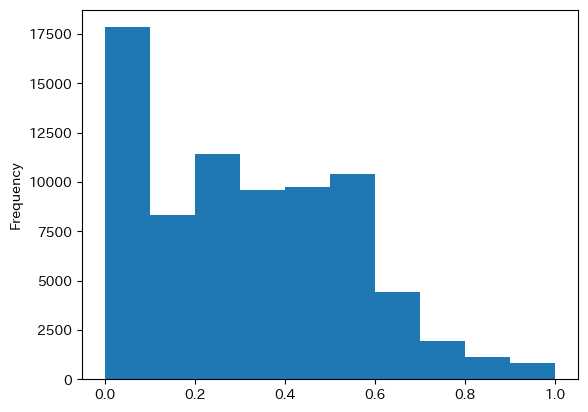

In [59]:
train["title_hiragana_rate"].plot(kind="hist")

It's interesting how many novels don't use hiragana at all in their titles.

<Axes: ylabel='Frequency'>

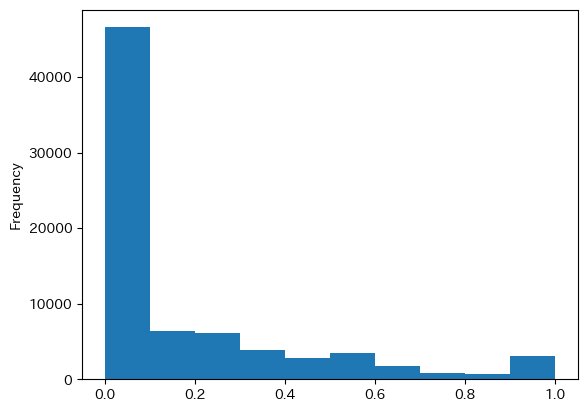

In [60]:
train["title_katakana_rate"].plot(kind="hist")

Most novels don't use katakana at all. But there's a certain minority with titles written entirely in katakana.

## Pairplot of title length and character density

In [61]:
train["title_length"] = train["title"].apply(len)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

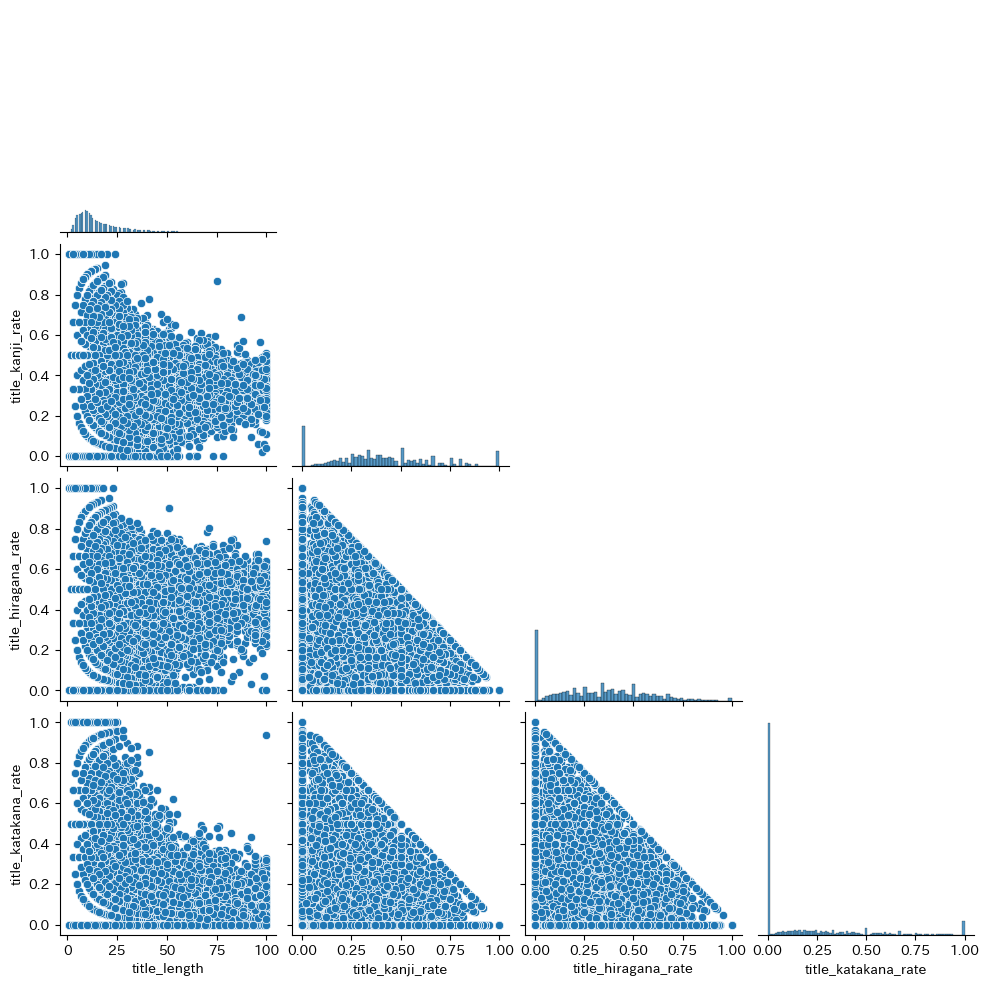

In [62]:
sns.pairplot(train[["title_length","title_kanji_rate","title_hiragana_rate","title_katakana_rate"]],corner=True)

Unsurprisingly, the more one writing system is used in the title, the less others are (thus the triangle shape of the distributions) What's noticable is the slight drop at both ends for the kanji - katakana/hiragana rates - if one system is used for >90% of the title, others are not

Other observations:

* Very long titles use a mix of writing systems, with the exception of apparently one outlier that used ~100 katakana characters for the title
* Longer titles written mostly in katakana are rarer than for other writing systems (steeper slope downwards in the plot)

# Training an xgboost model and using SHAP values to interpret its predictions

The shap module is useful for explaining the output of machine learning models. We will use it in the following manner:

1. We will train an xgboost model
2. Then we'll use shap to get shap values for our training data
3. Based on the shap values, we will try to interpret how the model makes predictions

This way we can find out which features are most important for predictions, and what values of the features lead to what outcomes.

For simplicity, we will ignore the (raw) novel title and keywords as they would require some special transformation:
* Titles would have to be tokenized and then embedded using either TF-IDF or a more modern technique (e.g. Fasttext)
* For keywords we'd probably have to one-hot encode them while filtering only to the most frequent ones

We will also ignore the `biggenre` column since knowing the `genre` already tells us what the value of that column will be.

Also, since the range of possible values is large and due to the metric used in the competition, we will use the log-transformed target variables.

We use the numpy `log1p` method for this. After training, to get our raw predictions we first call our model, and then use the inverse of our transformation - `expm1` method.

In [63]:
train["log_global_point"] = np.log1p(train["global_point"])

We will also process non-numeric variables as follows:
* yes/no columns to numeric (0/1)
* Genre to categorical


In [64]:
def string_binary_to_boolean(x):
    if x=="Yes":
        return True
    return False

binary_cols = ["isr15","isbl","isgl","iszankoku","istensei","istenni"]

for col in binary_cols:
    train[col] = train[col].apply(string_binary_to_boolean)

In [65]:
train["genre"] = train["genre"].astype("category")

In [66]:
numerical_cols = ["length_per_story","sasie_cnt_per_story","time_per_story_submission","kaiwaritu","title_length","title_kanji_rate","title_hiragana_rate","title_katakana_rate"]
for col in numerical_cols:
    train[col] = train[col].astype(np.float64)

In [67]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.1, random_state=42)

In [68]:
x_cols = ["genre","isr15","isbl","isgl","iszankoku","istensei","istenni","kaiwaritu","length_per_story","sasie_cnt_per_story","time_per_story_submission","title_length","title_kanji_rate","title_hiragana_rate","title_katakana_rate"]
y_col = ["log_global_point"]

In [69]:
train_x = train[x_cols]
valid_x = valid[x_cols]

train_y = train[y_col]
valid_y = valid[y_col]

In [70]:
import xgboost as xgb
custom_parameters = {
    "n_estimators": 1000,
    "max_depth": 6,
    "learning_rate": 0.1,
    "early_stopping_rounds": 10,
    "subsample": 1.0,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "enable_categorical": True,
    "seed": 42
    
}
model = xgb.XGBRegressor(**custom_parameters)

*Note: the reason we are log-transforming instead of using xgboost's reg:squaredlogerror is that that function has issues when during training the predicted value is less than -1.*

*I encountered this issue when experimenting with this dataset before, but when using manually log-transformed features it did not occur*

In [71]:
model.fit(train_x, train_y, 
            eval_set=[(valid_x, valid_y)]) 

[0]	validation_0-rmse:2.41939
[1]	validation_0-rmse:2.34471
[2]	validation_0-rmse:2.28376
[3]	validation_0-rmse:2.22815
[4]	validation_0-rmse:2.18048
[5]	validation_0-rmse:2.14270
[6]	validation_0-rmse:2.10840
[7]	validation_0-rmse:2.08199
[8]	validation_0-rmse:2.05812
[9]	validation_0-rmse:2.03775
[10]	validation_0-rmse:2.02087
[11]	validation_0-rmse:2.00448
[12]	validation_0-rmse:1.99216
[13]	validation_0-rmse:1.98177
[14]	validation_0-rmse:1.97259
[15]	validation_0-rmse:1.96430
[16]	validation_0-rmse:1.95780
[17]	validation_0-rmse:1.95248
[18]	validation_0-rmse:1.94631
[19]	validation_0-rmse:1.94088
[20]	validation_0-rmse:1.93648
[21]	validation_0-rmse:1.93275
[22]	validation_0-rmse:1.92930
[23]	validation_0-rmse:1.92608
[24]	validation_0-rmse:1.92349
[25]	validation_0-rmse:1.92099
[26]	validation_0-rmse:1.91924
[27]	validation_0-rmse:1.91722
[28]	validation_0-rmse:1.91530
[29]	validation_0-rmse:1.91322
[30]	validation_0-rmse:1.91133
[31]	validation_0-rmse:1.91022
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [72]:
1.89**2

3.5721

The validation rmse here is 1.89, which corresponds to around 3.57 for the metric used in the competition. 

It's not amazing (best solution in the leaderboard at the time of writing has score 2.8) but we DID ignore some useful columns for simplicities sake, and want to focus on interpretability.

In [73]:
!pip install shap==0.46.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1


In [74]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(train_x)

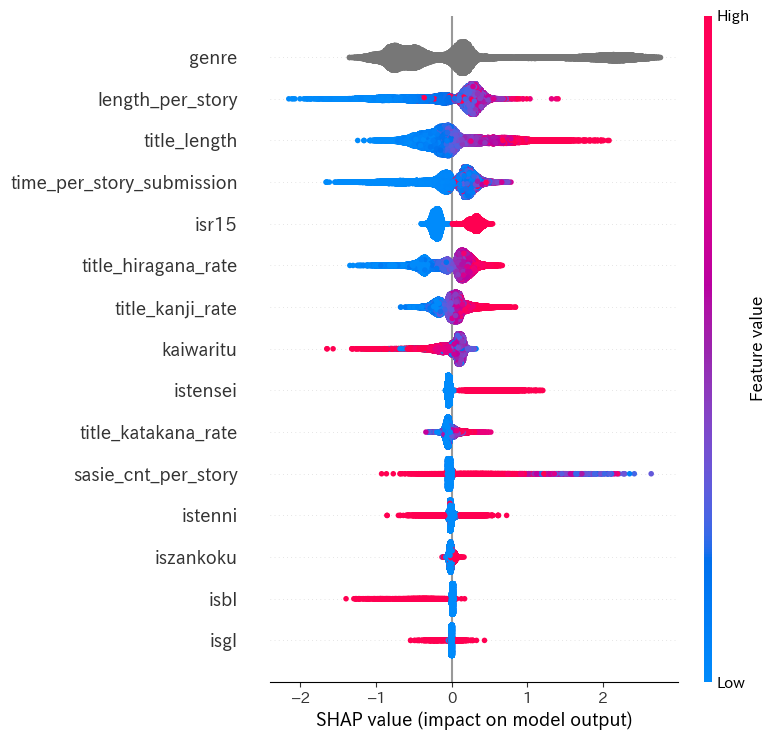

In [75]:
shap.summary_plot(shap_values)

The `genre` feature is displayed as grey above because it's categorical and as such cannot be sorted high/low.

At the same time, it appears to be the main feature used by the model to predict novel popularity. Therefore we will look at it more in-depth later

## Interpreting the SHAP results

The plot above tells us a lot about how our xgboost model makes decisions:

* The most important feature for predicting the popularity of a novel is the genre
* Chapters being short appears to negatively affect the novel's (predicted) popularity
* Long titles tend to improve the predicted popularity. This supports the approach of many Japanese writers trying to explain a lot of the story setting in the title.
* There is a clear trend where the 15+ rated novels appear to be more popular
* Utilizing the reincarnation (tensei) trope makes the model predict a higher popularity
* Adding the BL tag negatively affects the predicted popularity of a novel

There are four tags/variables that cause either a positive or negative effect on the predicted popularity of a novel, depending on the values of other variables:
* Including (a high number of) illustrations in a novel often yields a strong positive or negative effect on predicted popularity
* A similar effect occurs with the usage of the "transported to another world" trope
* Same with tagging a novel as including violent / cruel scenes, though the effect is much smaller
* The GL tag exhibits the same behavior during inference

High kanji, hiragana and katakana rates all increase predicted popularity, so it is somewhat difficult to untangle the exact relationship between these. It might be worth noting that hiragana rate was the most influential variable for the model out of the three, followed by kanji. Katakana is much less influential, but that might be related to how rarely it is used.

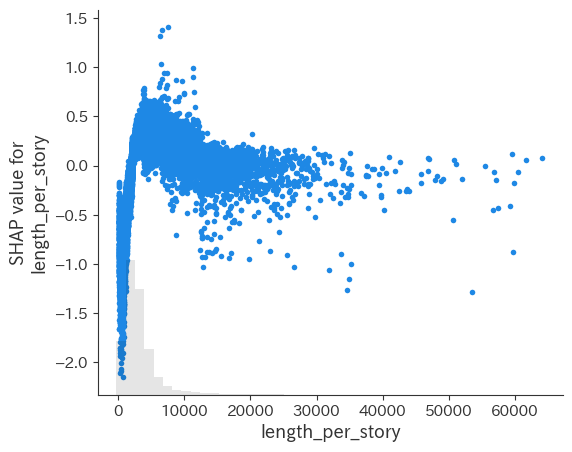

In [76]:
shap.plots.scatter(shap_values[:, "length_per_story"])

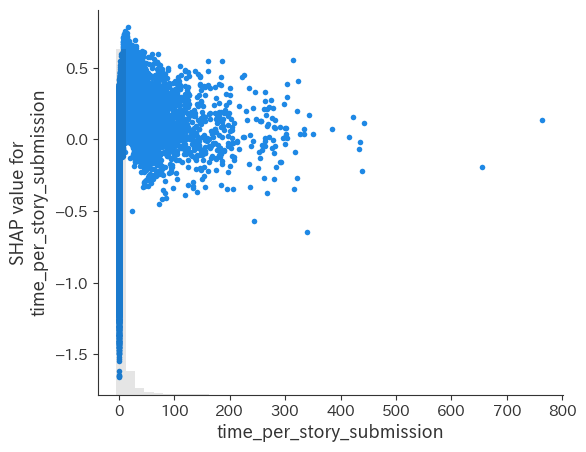

In [77]:
shap.plots.scatter(shap_values[:, "time_per_story_submission"])

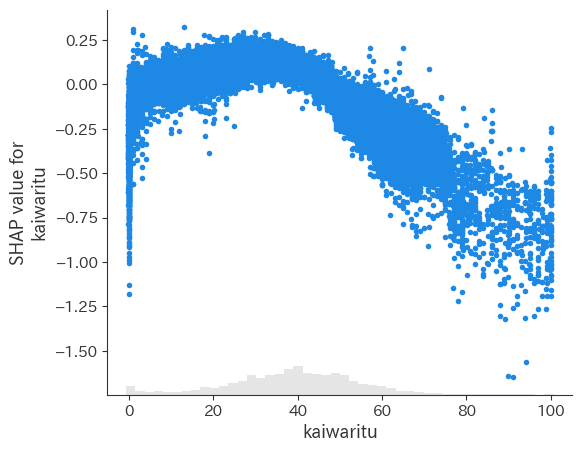

In [78]:
shap.plots.scatter(shap_values[:, "kaiwaritu"])

There appears to be a sweet spot around 40% of the novel being dialogue that's best for predicted popularity

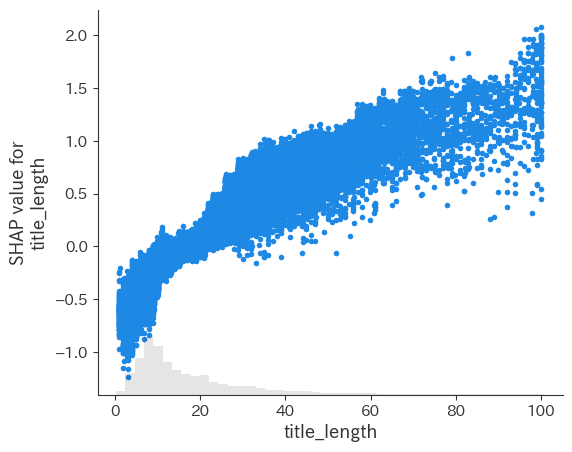

In [79]:
shap.plots.scatter(shap_values[:, "title_length"])

Novels with longer titles are systematically predicted as more popular, but for the extremely long ones (>70 characters) there's a much higher variance

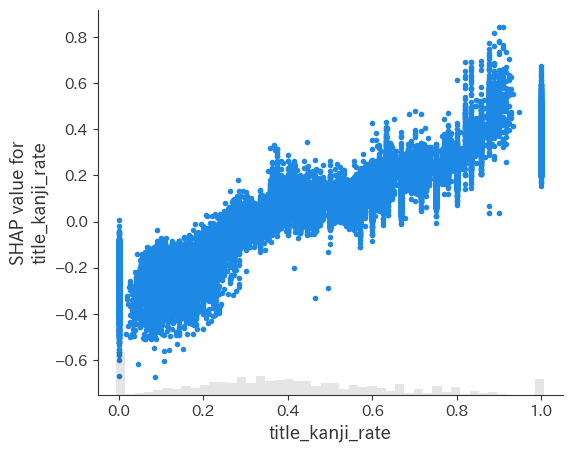

In [80]:
shap.plots.scatter(shap_values[:, "title_kanji_rate"])

There's a clear trend with titles that use more kanji being predicted as more popular

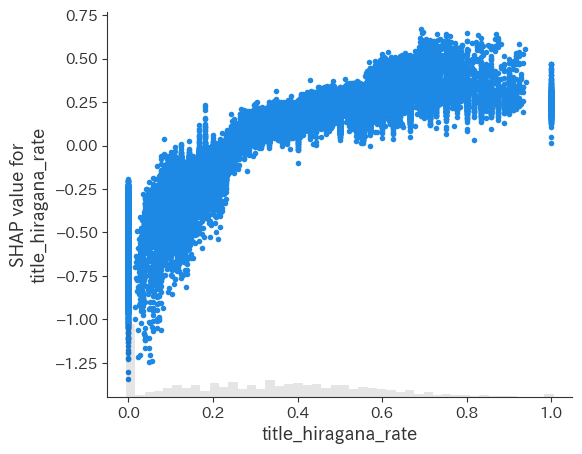

In [81]:
shap.plots.scatter(shap_values[:, "title_hiragana_rate"])

Same with hiragana, but the effect reaches its peak faster

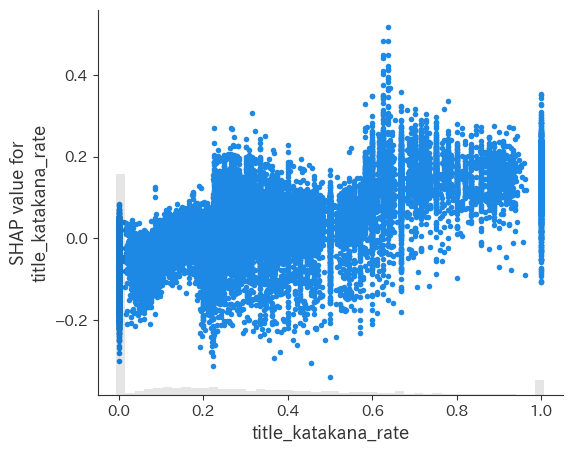

In [82]:
shap.plots.scatter(shap_values[:, "title_katakana_rate"])

The relationship between katakana rate and predicted popularity is much more chatoric

## Understanding individual predictions with waterfall plots

In [83]:
train_info = train[["title","log_global_point"]]

def explain_prediction(novel_id : int):
    novel_iloc = train.index.get_loc(novel_id)
    print(novel_iloc)
    print(f"Novel title: {train.loc[novel_id]['title']}")
    print(f"True score (log-transformed): {train.loc[novel_id]['log_global_point']}")
    shap.plots.waterfall(shap_values[novel_iloc])

In [84]:
train[train['title'].str.contains("転生したらスライムだった件|蜘蛛ですが、なにか？|死神を食べた少女")] # Looking for some specific, more popular novels

,novel_id,title,writer,biggenre,genre,keyword,isr15,isbl,isgl,iszankoku,...,sasie_cnt_per_story,time_per_story_submission,global_point,fav_novel_cnt,all_point,title_kanji_rate,title_hiragana_rate,title_katakana_rate,title_length,log_global_point
17055,17055,転スラ外伝[二人の少女の復讐劇] ～転生したらスライムだった件 勝手にスピンオフ ～,キューブック,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 異世界転移 二次創作 シリアス チート 復讐劇,True,False,False,True,...,0.000000,12.577297,2112.0,745.0,622.0,0.306122,0.183673,0.224490,49.0,7.655864
42860,42860,死神を食べた少女,七沢またり,ファンタジー,ハイファンタジー〔ファンタジー〕,残酷な描写あり ファンタジー 異世界 女主人公 劣勢 食欲 本編完結 戦記,False,False,False,True,...,0.027027,7.864942,117692.0,36016.0,45660.0,0.625000,0.375000,0.000000,8.0,11.675835
8695,8695,転生したらスライムだった件,伏瀬,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 スライム チート,True,False,False,True,...,0.016447,8.851891,878871.0,315117.0,248637.0,0.230769,0.461538,0.307692,13.0,13.686395
13635,13635,蜘蛛ですが、なにか？,馬場翁,ファンタジー,ハイファンタジー〔ファンタジー〕,R15 残酷な描写あり 異世界転生 ファンタジー 異世界 転生 蜘蛛 女主人公 勇者 魔王 ...,True,False,False,True,...,0.000000,4.061717,676799.0,209964.0,256871.0,0.200000,0.600000,0.000000,10.0,13.425131


45142
Novel title: 『文章の明晰化について』
True score (log-transformed): 3.044522437723423


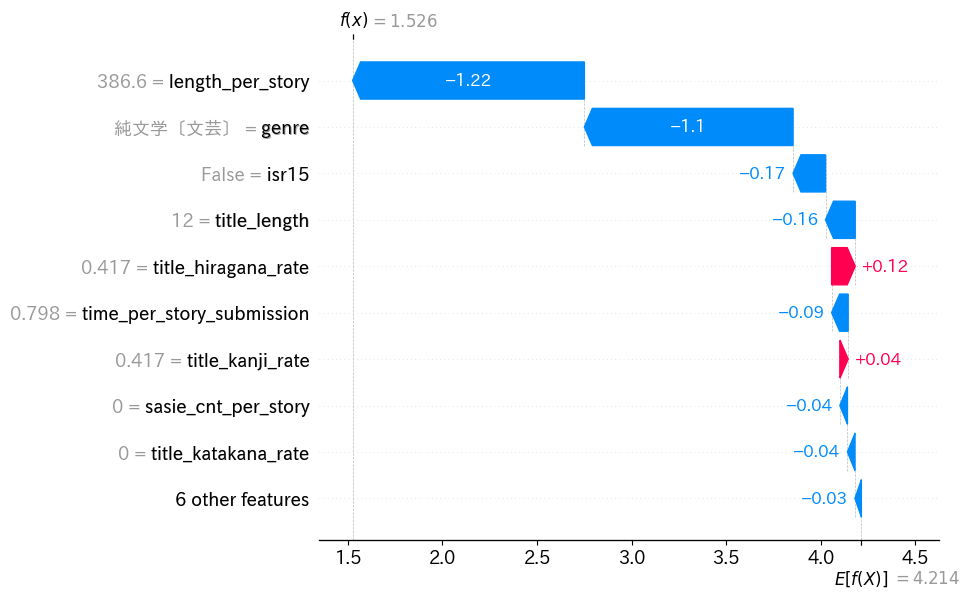

In [85]:
explain_prediction(115)

Short length of chapters was the main contribution to the low predicted popularity of this work. The genre (pure literature) also negatively affected the outcome.

29335
Novel title: 魔法探偵 天宮晴人の探し物
True score (log-transformed): 2.70805020110221


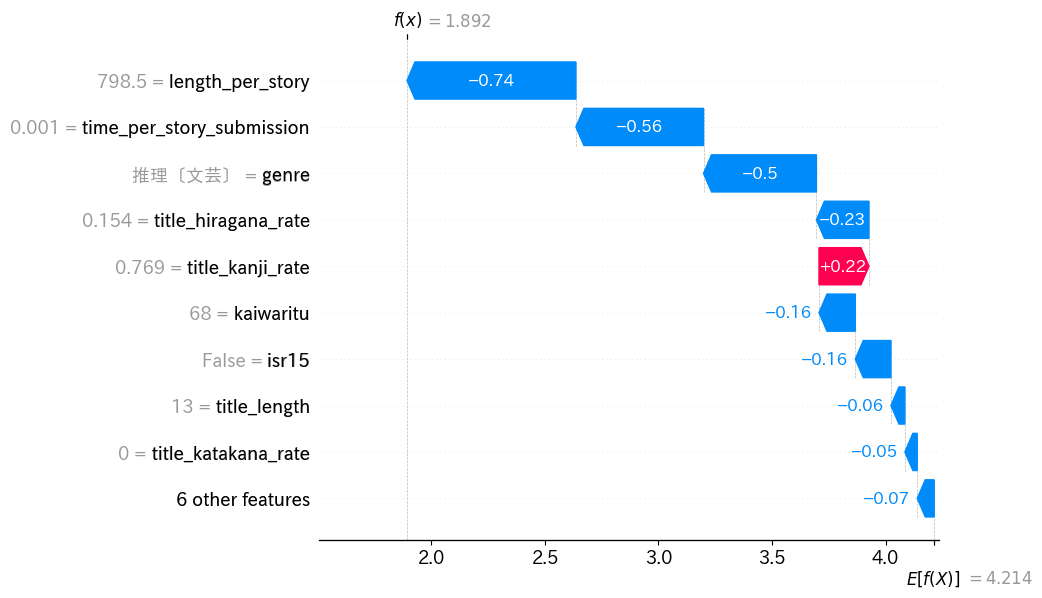

In [86]:
explain_prediction(25)

The low predicted popularity mainly stems from the following three features of the novel:
* Short chapters
* The novel was updated with new chapters very frequently (possibly the entire work was posted in one day)
* It's a (detective) mystery novel

The high amount of kanji in the title slightly boosted predicted popularity

47880
Novel title: 蜘蛛ですが、なにか？
True score (log-transformed): 13.425131087274151


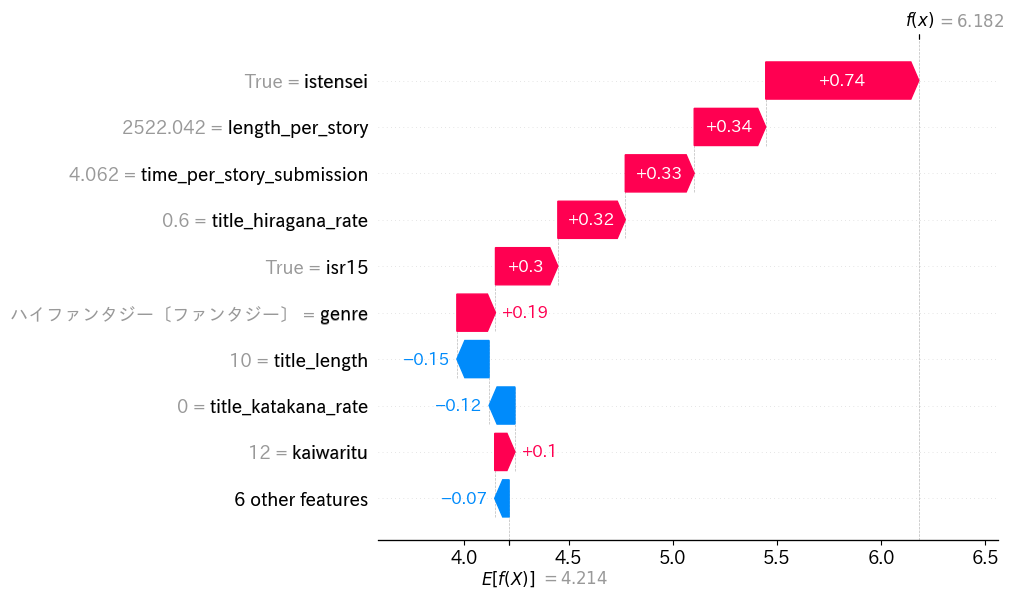

In [87]:
explain_prediction(13635)

This is the most popular novel in the train split. The model still under-approximated its popularity.

We can see that the combination of other variables (high length per story, frequent updates, a high fantasy setting (genre), 15+ rating) with the usage of the reincarnation trope leads to a high predicted popularity of the novel.

28617
Novel title: 転生したらスライムだった件
True score (log-transformed): 13.686394546040937


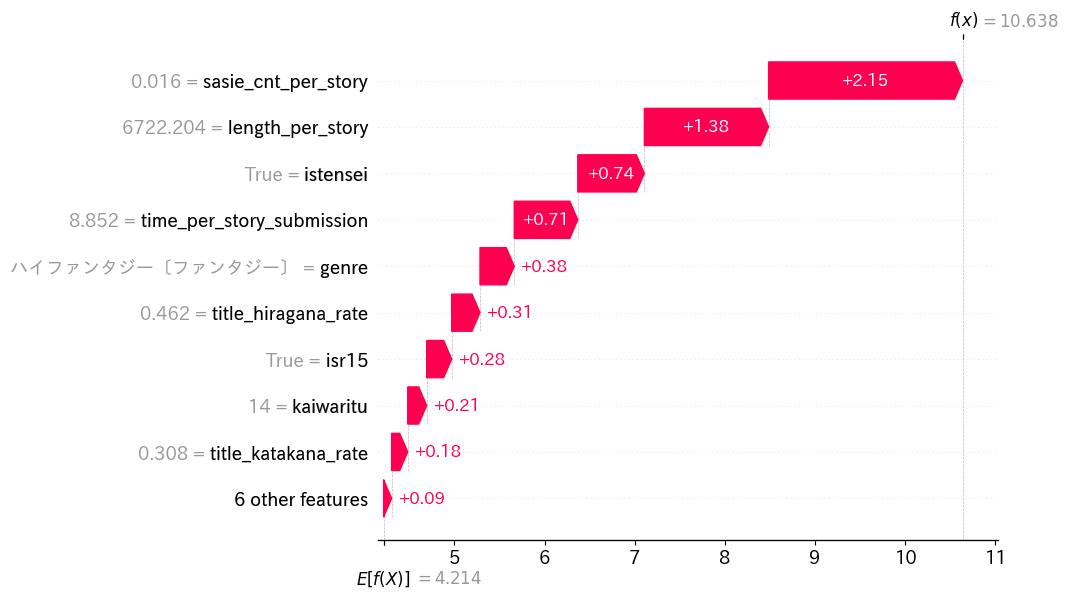

In [88]:
explain_prediction(8695)

The results here are similar to 蜘蛛ですが (...), but the author of this novel added some illustrations which increased the predicted popularity.

It's interesting to see that both of the previous examples had relatively low amounts of dialogue - 12 and 14 % respectively.

20612
Novel title: 死神を食べた少女
True score (log-transformed): 11.675834818242722


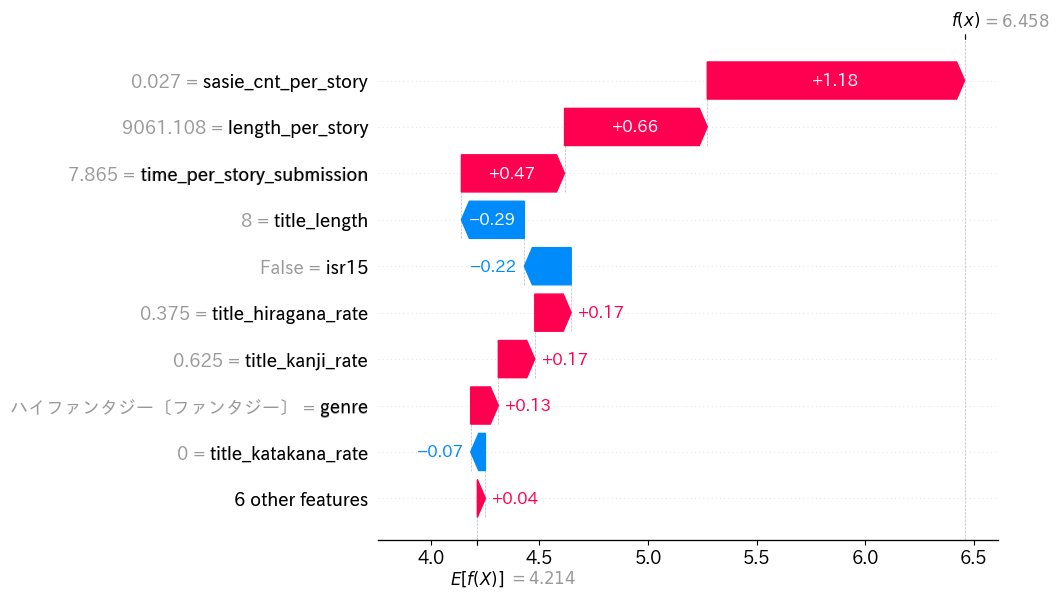

In [89]:
explain_prediction(42860)

This is similar to the previous example, but the novel is not tagged as r15 or tenni/tensei which dropped its predicted popularity by some amount.

## Investigating the impact of the genre on predicted popularity

Since there are no built-in functions for visualizing the impact of a categorical variable on model output in shap, we will instead group the shap values for the `genre` variable by its value, and then figure out the averages for each genre

In [90]:
shap_values[:, "genre"]

.values =
array([ 0.1080698 , -0.9783889 ,  0.21658999, ..., -0.23374812,
        0.16479221, -0.3944858 ], dtype=float32)

.base_values =
array([4.2144113, 4.2144113, 4.2144113, ..., 4.2144113, 4.2144113,
       4.2144113], dtype=float32)

.data =
array(['現実世界〔恋愛〕', '純文学〔文芸〕', 'ハイファンタジー〔ファンタジー〕', ..., 'ノンジャンル〔ノンジャンル〕',
       'ハイファンタジー〔ファンタジー〕', 'コメディー〔文芸〕'], dtype=object)

In [91]:
genre_vals = shap_values[:, "genre"].values

In [92]:
genre_ids = shap_values[:, "genre"].data

In [93]:
genre_df = pd.DataFrame({"shap_value":genre_vals, "genre": genre_ids})

In [94]:
genre_df.groupby("genre").mean().sort_values(by="shap_value")

,shap_value
genre,
リプレイ〔その他〕,-1.028168
純文学〔文芸〕,-0.948218
アクション〔文芸〕,-0.936636
その他〔その他〕,-0.921088
空想科学〔SF〕,-0.797813
ホラー〔文芸〕,-0.752349
ヒューマンドラマ〔文芸〕,-0.745624
ローファンタジー〔ファンタジー〕,-0.692553
童話〔その他〕,-0.620676


<Axes: xlabel='genre'>

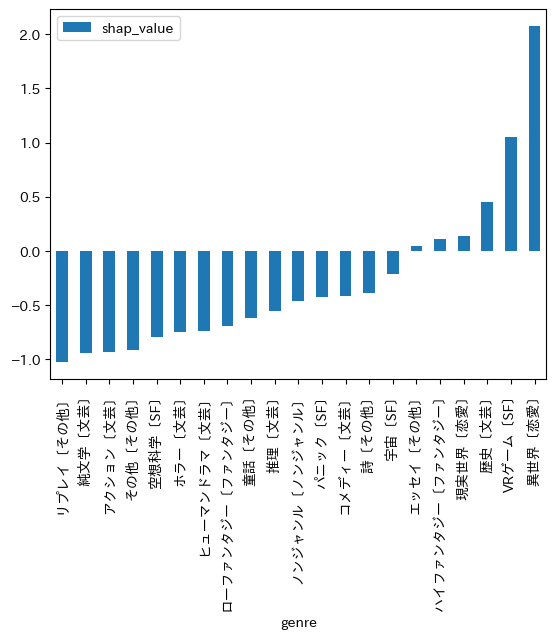

In [95]:
genre_df.groupby("genre").mean().sort_values(by="shap_value").plot(kind="bar") # Mean

<Axes: xlabel='genre'>

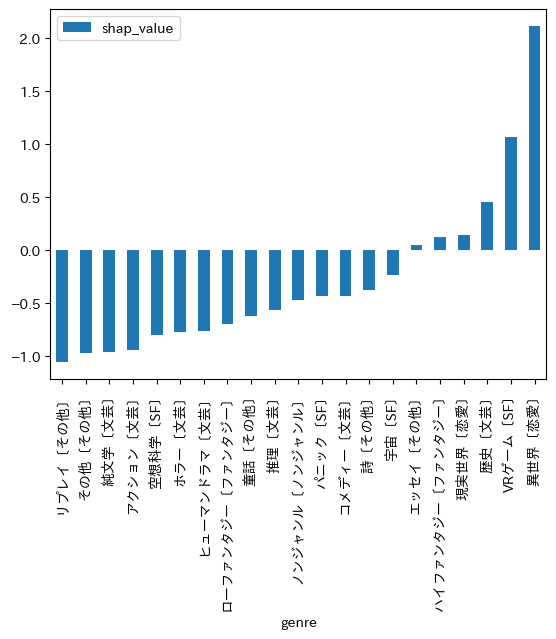

In [96]:
genre_df.groupby("genre").median().sort_values(by="shap_value").plot(kind="bar") # Median

There are a couple genres that positively affect the predicted popularity (notably isekai, vr-game and historical), but most of them negatively affect the predicted value.

The least popular genre would appear to be the replays of TTRPG games, followed by pure literature.

It's also interesting to see that on average the high fantasy tag has a positive effect on predicted popularity, while low fantasy a negative.

# Additional thoughts / remarks

It would be useful if the data contained a `date posted` column for the novels (either for the initial upload or a "last updated" date). We could then:

* Use it for prediction, since it would make sense that older novels "had more time" to get more upvotes
* Check how the popularity of different genres changed over time

# Possible applications

As mentioned on the competition page, analyzing this data can help writers decide what they can do to get more people interested in what they write. This doesn't only apply to changing *how they write* - it's also about conveying this information to syosetu users by applying the appropriate tags.

This data is also potentially useful for publishers who would want to focus their efforts on funding and cooperating with those writers whose novels have good prospects, and there is a good statistical basis for it.

Moreover, it's interesting to notice some peculiar charactersitics of the modern syosetu ecosystem - for example, the popularity of the isekai genre and very long titles. We can see that it is no accident that it's this way - novels having those charactersitics really are more popular.